In [2]:
# default_exp thompson_sampler

# thompson_sampler
> implementation of the thompson samplers 

In [3]:
# export

import numpy as np 
import matplotlib.pyplot as plt
import scipy.stats as stats
import matplotlib.cm as cm


class GaussianBandit(object):

    def __init__(self, num_options = 2, mean_prior = 0, std_prior = 1):
        """initialize BetaBandit"""
        self.num_options = num_options

        #setting the prior, either uninformative or user generated
#         if prior == None:
#             self.prior = np.ones(shape=(num_options,2))
#         else:
#             assert prior.shape == (num_options,2), f"the prior seems to have wrong dimensionality, please conform to (num_options, 2){(num_options,2)}"
#             self.prior = prior

        self.trials = np.zeros(shape=(num_options,))
        self.sum_x = np.zeros(shape=(num_options,))
        self.sum_x2 = np.zeros(shape=(num_options,))

        self.mean_prior = mean_prior
        self.std_prior = std_prior

    def choose_arm(self):
        """draw from arms.
        arm with the highest expected outcome wins. 
        expected outcome is determined stochastically, so even an arm with bad 
        outcome until now will have a chance of being drawn"""

        sampled_outcomes = []
        for i in range(self.num_options):
            
            if self.trials[i] > 1:
                mean = self.compute_online_mean(i)
                stdev = self.compute_online_std(i, mean)
            else:
                mean = 0
                stdev = 1
            

            dist = stats.norm(mean,stdev)
            
            sampled_outcome = dist.rvs()
            #print(sampled_outcome)
            
            sampled_outcomes += [sampled_outcome]
            
        return np.argmax(sampled_outcomes)
      
        #return(sampled_outcomes.argmax(sampled_outcomes))   
        
    def update(self, arm, outcome):
        """update parameters of specific arm"""
        #count times arm has been drawn"""
        self.trials[arm] = self.trials[arm] +1
        #count number of successes on that arm"""

        # for decay factors: self.successes = self.successes *.99
        
        self.sum_x[arm] += outcome
        self.sum_x2[arm] += outcome*outcome
        
        
    def compute_online_mean(self, arm):
        return self.sum_x[arm] / (self.trials[arm])
    
    def compute_online_std(self, arm, mean = None):
        mean = mean or self.compute_online_mean(arm)
        #np max against degeneration)
        return np.max([np.sqrt((self.sum_x2[arm] / (self.trials[arm])) - (mean * mean)), 0.00001])
        
        

        
    def plot_params(self):
        """plot the distributions that underly the arms"""
        
        w = 10
        z = 5
        colors = iter(cm.rainbow(np.linspace(0, 1, self.num_options)))
            
        for k,i in enumerate(range(self.num_options)):
                color = next(colors)
                
                
            
            
                if self.trials[i] > 1:
                    mean = self.compute_online_mean(i)
                    stdev = self.compute_online_std(i, mean)
                else:
                    mean = 0
                    stdev = 1


                dist = stats.norm(mean,stdev)

                x = np.linspace(-6,6,100)
                y = dist.pdf(x)
                plt.plot(x,y,color=color,label="arm #%i"%(i+1))
                plt.fill_between(x,0,y,alpha=1/self.num_options,color=color)
                leg = plt.legend()
                plt.tight_layout
     

            



Bad key "text.kerning_factor" on line 4 in
/home/thomas/anaconda3/envs/pytorch_GPU/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


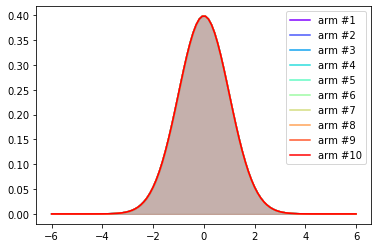

In [4]:
%matplotlib inline

num_arms = 10
gb = GaussianBandit(num_arms)

gb.plot_params()

In [5]:
np.mean([gb.choose_arm() for x in range(100)]), np.histogram([gb.choose_arm() for x in range(100)], bins=list(range(num_arms)))

(4.19,
 (array([10,  8,  8, 10, 11, 13, 14, 10, 16]),
  array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])))

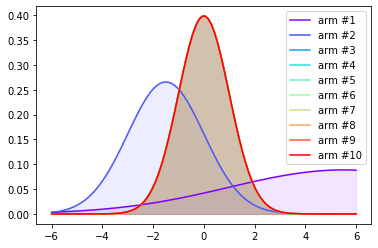

In [6]:
gb.update(0, 10)
gb.update(0, 1)
gb.update(1, -3)
gb.update(1, 0)

gb.plot_params()

In [7]:
np.mean([gb.choose_arm() for x in range(100)]), np.histogram([gb.choose_arm() for x in range(100)], bins=list(range(num_arms)))

(0.45,
 (array([83,  0,  1,  2,  2,  8,  2,  1,  1]),
  array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])))

# Contextual

## models


In [11]:
#export 


class BayesLinReg:

    def __init__(self, n_features, alpha, beta):
        self.n_features = n_features
        self.alpha = alpha
        self.beta = beta
        self.mean = np.zeros(n_features)
        self.cov_inv = np.identity(n_features) / self.alpha

    def observe(self, x, y):

        # Update the inverse covariance matrix (Bishop eq. 3.51)
        cov_inv = self.cov_inv + self.beta * np.outer(x, x)

        # Update the mean vector (Bishop eq. 3.50)
        cov = np.linalg.inv(cov_inv)
        mean = cov @ (self.cov_inv @ self.mean + self.beta * y * x)

        self.cov_inv = cov_inv
        self.mean = mean

        return self
    
    def learn(self,X,y):
        "until refactoring..."
        self.observe(X,y)

    def predict(self, x):

        # Obtain the predictive mean (Bishop eq. 3.58)
        y_pred_mean = x @ self.mean

        # Obtain the predictive variance (Bishop eq. 3.59)
        w_cov = np.linalg.inv(self.cov_inv)
        y_pred_var = 1 / self.beta + x @ w_cov @ x.T

        return stats.norm(loc=y_pred_mean, scale=y_pred_var ** .5)

    @property
    def weights_dist(self):
        cov = np.linalg.inv(self.cov_inv)
        return stats.multivariate_normal(mean=self.mean, cov=cov)


class BatchBayesLinReg(BayesLinReg):

    def observe(self, x, y):

        # If x and y are singletons, then we coerce them to a batch of length 1
        x = np.atleast_2d(x)
        y = np.atleast_1d(y)

        # Update the inverse covariance matrix (Bishop eq. 3.51)
        cov_inv = self.cov_inv + self.beta * x.T @ x

        # Update the mean vector (Bishop eq. 3.50)
        cov = np.linalg.inv(cov_inv)
        mean = cov @ (self.cov_inv @ self.mean + self.beta * y @ x)

        self.cov_inv = cov_inv
        self.mean = mean

        return (self.predict(x).mean() - y)**2
    
    def learn(self,X,y):
        "until refactoring..."

        self.observe(X,y)

    def predict(self, x):

        x = np.atleast_2d(x)

        # Obtain the predictive mean (Bishop eq. 3.58)
        y_pred_mean = x @ self.mean

        # Obtain the predictive variance (Bishop eq. 3.59)
        w_cov = np.linalg.inv(self.cov_inv)
        y_pred_var = 1 / self.beta + (x @ w_cov * x).sum(axis=1)

        # Drop a dimension from the mean and variance in case x and y were singletons
        # There might be a more elegant way to proceed but this works!
        y_pred_mean = np.squeeze(y_pred_mean)
        y_pred_var = np.squeeze(y_pred_var)

        return stats.norm(loc=y_pred_mean, scale=y_pred_var ** .5)

## solvers

In [13]:
#export

from collections import OrderedDict


class AbstractContextualSolver(object):
    def __init__(self, model_type, num_arms, num_context, model_params={}):
        self.model_list = [model_type(num_context, **model_params) for x in range(num_arms)]
        self.num_arms = num_arms
        self.num_context = num_context


    def choose_arm(self,context):
        """choose an arm to play according to internal policy"""
        raise NotImplementedError
        
    def update(self, arm, context, reward):
        """ update internal policy to reflect changed knowledge"""
        raise NotImplementedError
        
        


class GaussianContextualSampler(AbstractContextualSolver):

    
    def update(self,arm,context,reward):
        
        model = self.model_list[arm]
        X = np.atleast_2d(context)
    
        reward = np.atleast_1d(reward)
        model.observe(X, reward)
        
    def choose_arm(self,context):
        reward_list = []
        
        

        for arm in range(self.num_arms):
            model = self.model_list[arm]
            X = np.atleast_2d(context)
            
            arm_dist = model.predict(X)
            

            reward_sample = arm_dist.rvs()
            
        
            reward_list += [reward_sample]

            
      
        return np.argmax(reward_list)     
    
    
    
    
      
        
    def choose_arm_and_plot(self,context):
        colors = iter(cm.rainbow(np.linspace(0, 1, self.num_arms)))
        reward_list = []

        



        for arm in range(self.num_arms):
            model = self.model_list[arm]
            X = np.atleast_2d(context)

            arm_dist = model.predict(X)


            reward_sample = arm_dist.rvs()


            reward_list += [reward_sample]


            
            # plot
            color = next(colors)

            model = self.model_list[arm]
            X_pdf = np.linspace(-10, 10, 1000)
            pdf = arm_dist.pdf(X_pdf)
            
            height = arm_dist.pdf(reward_sample)


            # plotting distriution of weights
            plt.plot(X_pdf, pdf, color=color, linewidth=2, alpha=0.5, label=f'estimated parameter arm {arm}')
            plt.fill_between(X_pdf, pdf, 0, color=color, alpha=0.2)

            
            plt.scatter(reward_sample, height, s = 200,label=f'sample drawn from arm {arm}')

            plt.legend()
        return np.argmax(reward_list)

class GaussianCategoricalBandit(GaussianBandit):


    def choose_arm(self):
        """draw from arms.
        arm with the highest expected outcome wins.
        expected outcome is determined stochastically, so even an arm with bad
        outcome until now will have a chance of being drawn"""

        sampled_outcomes = []
        arm_samples = np.zeros(shape=(self.num_options,100))
        for arm in range(self.num_options):

            for i in range(100):

                if self.trials[arm] > 1:
                    mean = self.compute_online_mean(arm)
                    stdev = self.compute_online_std(arm, mean)
                else:
                    mean = 0
                    stdev = 1


                dist = stats.norm(mean,stdev)

                arm_samples[arm,i] = dist.rvs()

        winning_ratio = np.argmax(arm_samples,0)

        winning_arm = np.bincount(winning_ratio).argmax()


        # ToDo sample from ratio of winning arms, i.e. nb.bincount(winning_ratio).mean()
        return winning_arm



    def choose_arm_and_plot(self):
        print('this is not implemented, will not plot the distribution, please also call plot arm')
        return self.choose_arm()




# Cell
class GaussianUniversalContextualSampler(GaussianContextualSampler):


    def update(self,arm,context,reward):

        model = self.model_list[arm]
        X = np.atleast_2d(context)

        reward = np.atleast_1d(reward)
        model.observe(X, reward)






    def choose_arm(self, context, num_samples = 10):
        """draw from arms.
        arm with the highest expected outcome wins.
        expected outcome is determined stochastically, so even an arm with bad
        outcome until now will have a chance of being drawn"""

        sampled_outcomes = []
        arm_samples = np.zeros(shape=(self.num_arms,num_samples))

        X = np.atleast_2d(context)

        for arm in range(self.num_arms):
            model = self.model_list[arm]
            arm_dist = model.predict(X)


            for i in range(num_samples):

                arm_samples[arm,i] = arm_dist.rvs()

        winning_ratio = np.argmax(arm_samples,0)

        winning_arm = np.bincount(winning_ratio).argmax()


        # ToDo sample from ratio of winning arms, i.e. nb.bincount(winning_ratio).mean()
        return winning_arm



In [17]:

#export
def contextual_numerical_bandit(context:np.array, choice:int, theta:np.array, noise=float)->float:
    features  = np.append(context,choice)

    # decide on which slope to use depending on whether a dog is present or not
    m = theta[0] if features[1] else theta[1]
    intercept = 0 if features[1] else 0

    # $y = x \cdot m + t + \epsilon $
    y = features[0] * m + intercept +  np.random.normal(0,noise)


    return y



def contextual_numerical_get_optimal_arm(context):
    if context < 0:
        return 1
    return 0

0

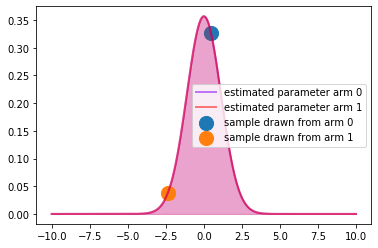

In [24]:
gucs = GaussianUniversalContextualSampler(BatchBayesLinReg,num_arms=2, num_context = 1,model_params={'alpha':1, 'beta':4})
gucs.choose_arm_and_plot(1)


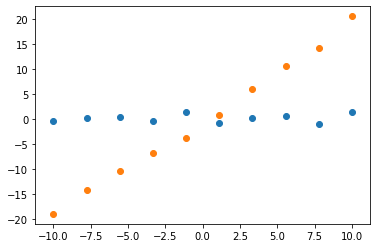

In [18]:
arm0 = 0
arm1 = 1
theta = [0.1, 1.9]
noise = 1



X = np.linspace(-10,10, 10)
y0 = [contextual_numerical_bandit(x,0,theta,noise) for x in X]
y1 = [contextual_numerical_bandit(x,1,theta,noise) for x in X]

plt.scatter(X,y1)
plt.scatter(X,y0)

In [25]:
arm0 = 0
arm1 = 1
theta = [0.1, 1.9]
noise = 0.0


contexts = [10,-10,-1,9.5,-9,1]

a = [gucs.update(arm1, context, contextual_numerical_bandit(context = np.array(context),choice = arm1, theta = theta, noise = noise)) for context in contexts]
a = [gucs.update(arm1, context, contextual_numerical_bandit(context = np.array(context),choice = arm1, theta = theta, noise = noise)) for context in contexts]
a = [gucs.update(arm1, context, contextual_numerical_bandit(context = np.array(context),choice = arm1, theta = theta, noise = noise)) for context in contexts]

1

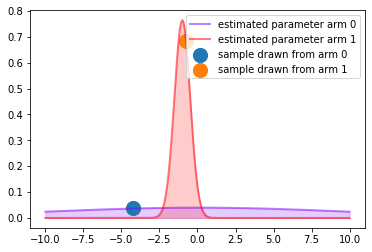

In [28]:
gucs.choose_arm_and_plot(-10)


0

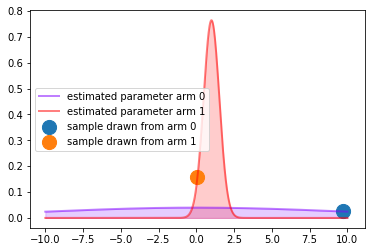

In [29]:
gucs.choose_arm_and_plot(10)


0

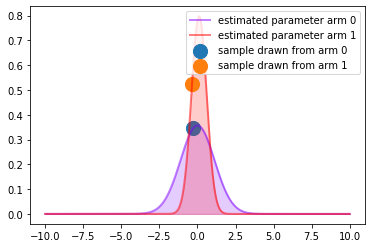

In [30]:
gucs.choose_arm_and_plot(1)
